<ipython-input-8-633d4833ec10>:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  selected_data = selected_data.fillna(method='ffill')
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


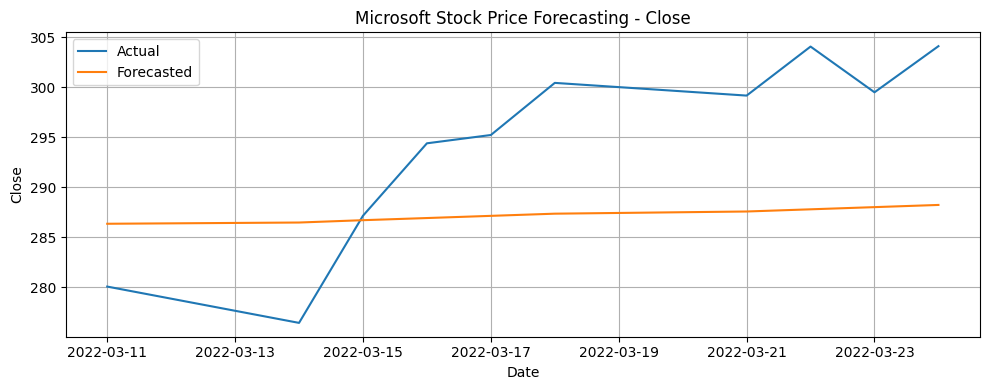

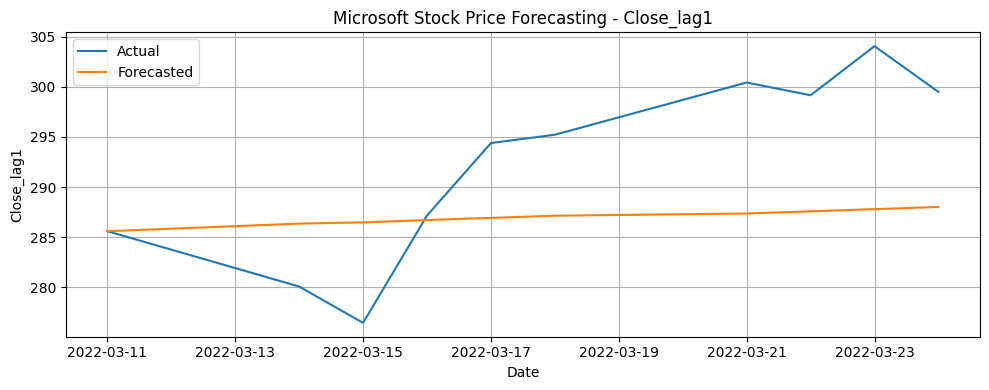

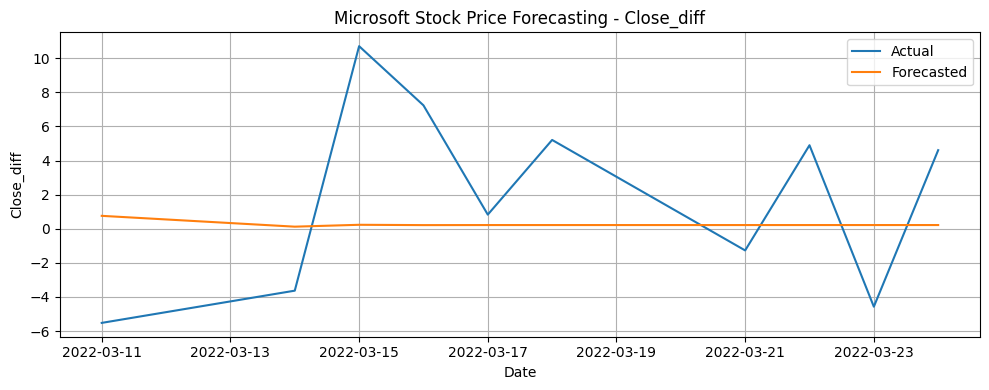

RMSE for Close: 11.02
RMSE for Close_lag1: 9.81
RMSE for Close_diff: 5.52


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error

# Load the dataset
try:
    df = pd.read_csv("/content/MSFT.csv", parse_dates=['Date'], index_col='Date')
except KeyError:
    # If 'Date' column is not found, try using 'Month'
    try:
        df = pd.read_csv("/content/MSFT.csv", parse_dates=['Month'], index_col='Month')
    except KeyError:
        print("Error: Neither 'Date' nor 'Month' column found in CSV for parsing dates.")
        exit(1)

# Check if 'Close' column exists, otherwise print available columns
data_column = None
if 'Close' in df.columns:
    data_column = 'Close'  # Use 'Close' for Microsoft stock data
else:
    print("Error: 'Close' column not found in CSV. Available columns:")
    print(df.columns)
    exit(1)

# Create synthetic multivariate dataset using lag features
# We'll use 'Close' as the main data column
df['Close_lag1'] = df[data_column].shift(1)  # Lagged Close price
df['Close_diff'] = df[data_column].diff()  # Difference in Close price

# Drop initial NaN values caused by shifting
selected_data = df[[data_column, 'Close_lag1', 'Close_diff']].dropna()

# Forward fill if needed (generally clean after diff/shift)
selected_data = selected_data.fillna(method='ffill')

# Forecast horizon
n_obs = 10
df_train = selected_data[:-n_obs]
df_test = selected_data[-n_obs:]

# Fit VAR model
model = VAR(df_train)
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(df_train.values[-model_fit.k_ar:], steps=n_obs)
forecast_df = pd.DataFrame(forecast, index=df_test.index, columns=selected_data.columns)

# Plotting actual vs forecasted
for column in selected_data.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(df_test[column], label='Actual')
    plt.plot(forecast_df[column], label='Forecasted')
    plt.title(f'Microsoft Stock Price Forecasting - {column}')  # Title updated
    plt.xlabel(df.index.name)
    plt.ylabel(column)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Print RMSE
for column in selected_data.columns:
    rmse = np.sqrt(mean_squared_error(df_test[column], forecast_df[column]))
    print(f'RMSE for {column}: {rmse:.2f}')